In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
datasetArray = []
visualiseDataSets = True
def create_df_from_sheet(sheet: str) -> pd.DataFrame:
    df = pd.read_excel("./all data(from manon).xlsx", sheet_name=sheet)
    df.columns = df.iloc[1]
    df = df.iloc[2:]
    if len(df.columns) > 4:
        df.drop(columns=df.columns[-2:], axis=1, inplace=True)
    df.columns = ["timestamp", "no_units", "RangeCAL_uS", "SkinResistanceCAL_kOhms"]

    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y/%m/%d %H:%M:%S.%f') # change the string formatted times to pandas datetime
 
    df['timestamp'] = df.timestamp-df.timestamp[2] # convert the time to relative from the start of the measurements

    # print(df['timestamp'])
    datasetArray.append(df)
    return df


def plot_df(df: pd.DataFrame):
    if visualiseDataSets:
        df.iloc[:, [0, 1]].plot(x='timestamp', ylim=[0,3.1],xlabel='Time', ylabel='Calibration mode', rot=45)
        df.iloc[:, [0, 2]].plot(x='timestamp', xlabel='Time', ylabel='Galvanic skin response', rot=45)
        df.iloc[:, [0, 3]].plot(x='timestamp', xlabel='Time', ylabel='Skin resistance', rot=45)
        # print("hi mom")



# Loading data
Here we load the data from the excel sheets and plot it to give a general idea of what the data looks like

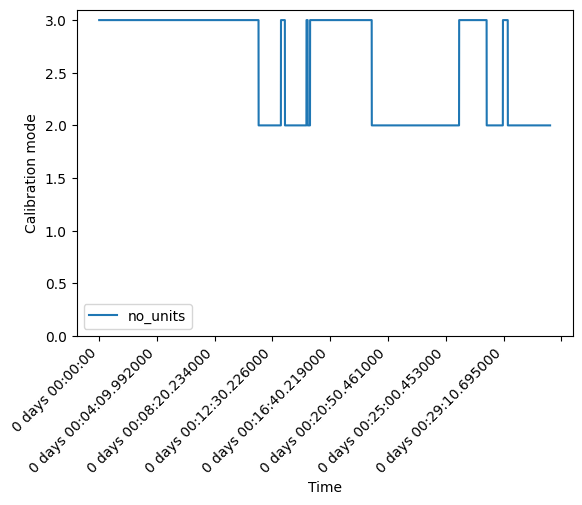

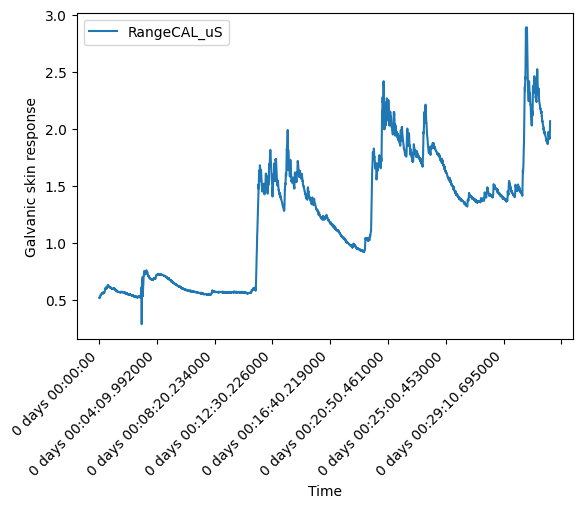

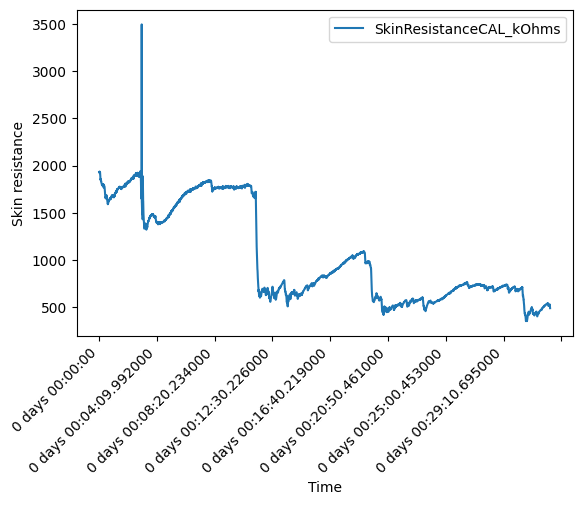

In [2]:
test612_1 = create_df_from_sheet("612_1")
plot_df(test612_1)

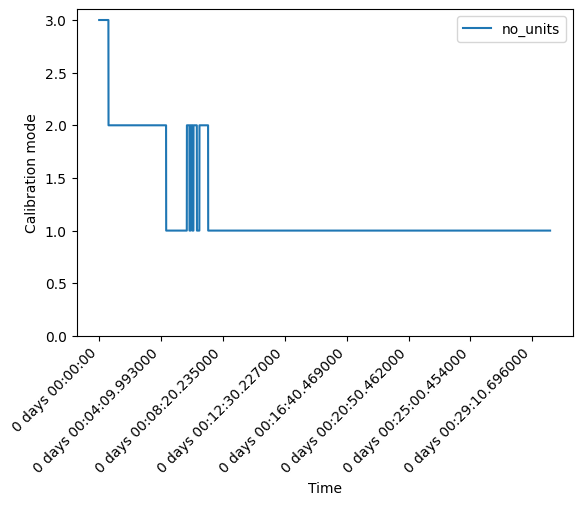

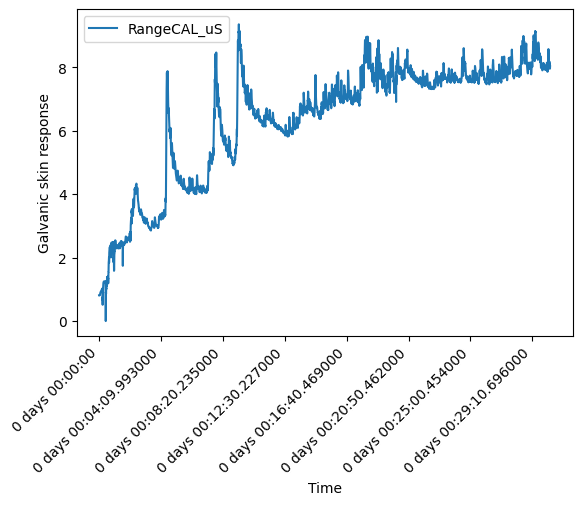

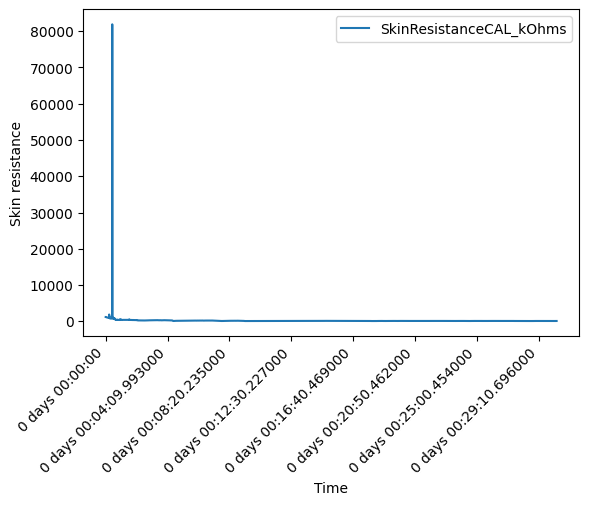

In [3]:
test612_2 = create_df_from_sheet("612_2")
plot_df(test612_2)

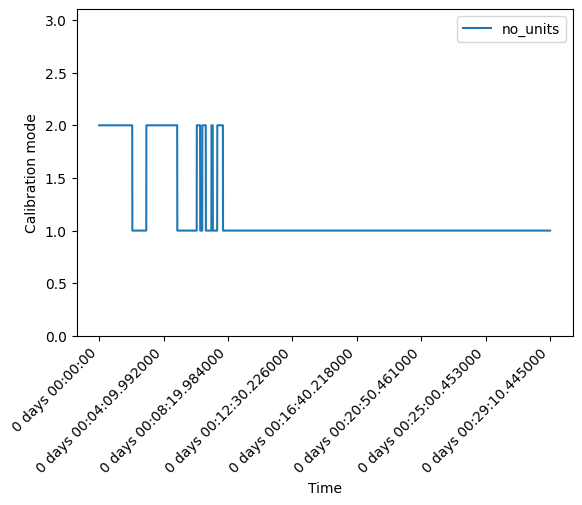

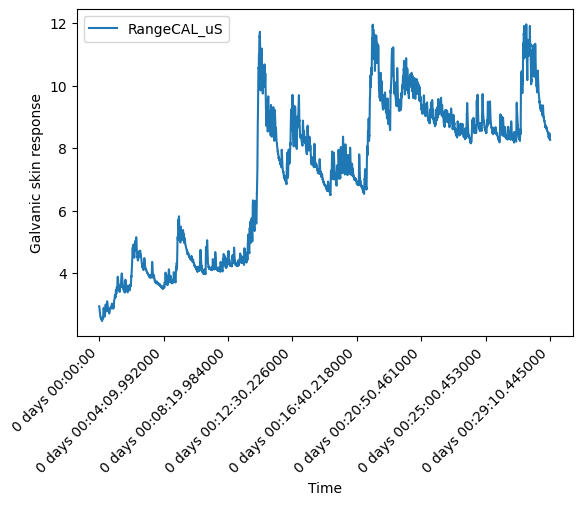

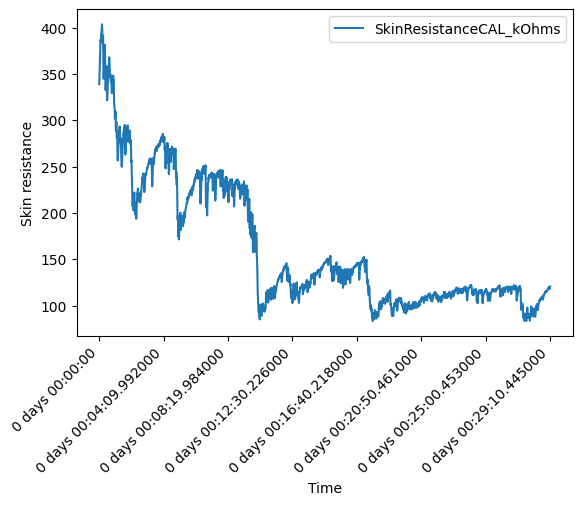

In [4]:
test612_3 = create_df_from_sheet("612_3")
plot_df(test612_3)

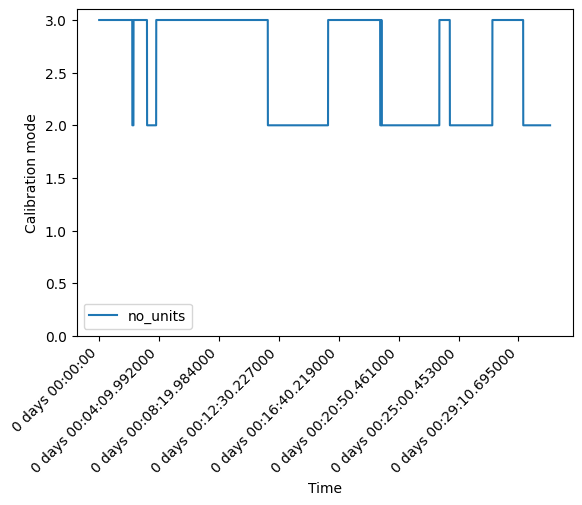

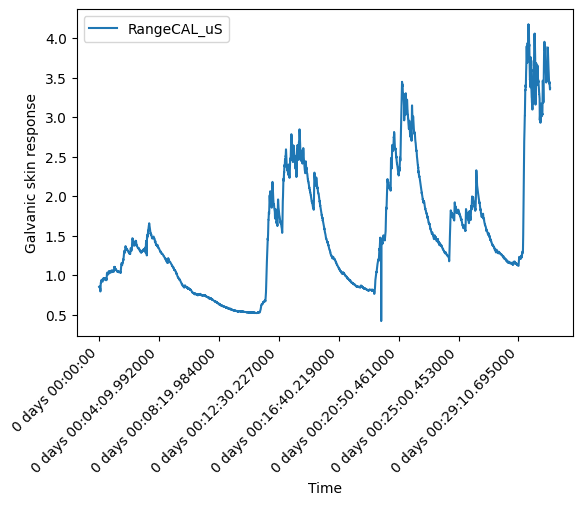

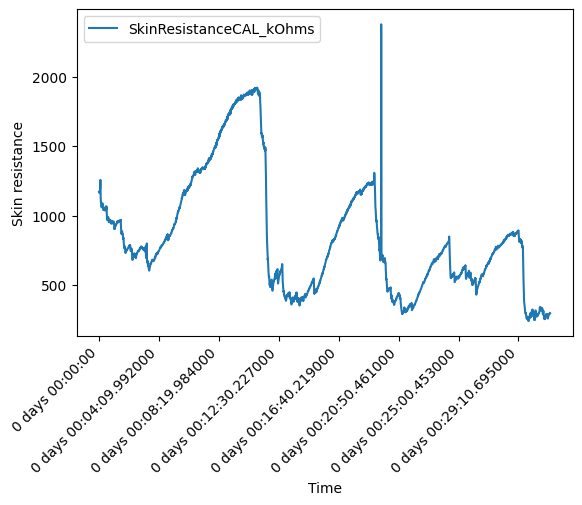

In [5]:
test612_4 = create_df_from_sheet("612_4")
plot_df(test612_4)

In [6]:
## BAD DATA SET
# lots of noise and no clear correlation with the tests that occurred.
# test612_5 = create_df_from_sheet("612_5")
# plot_df(test612_5)

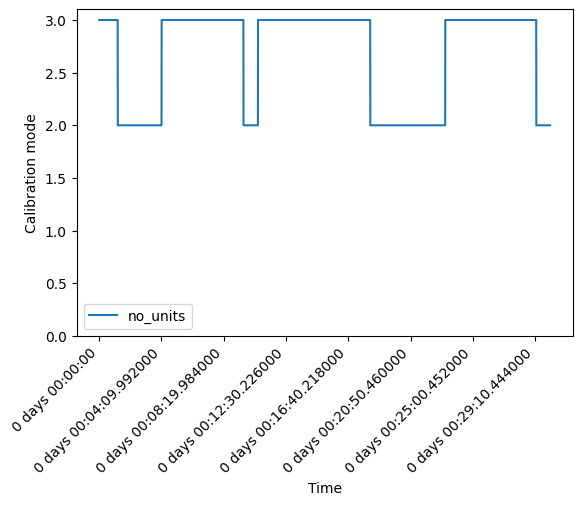

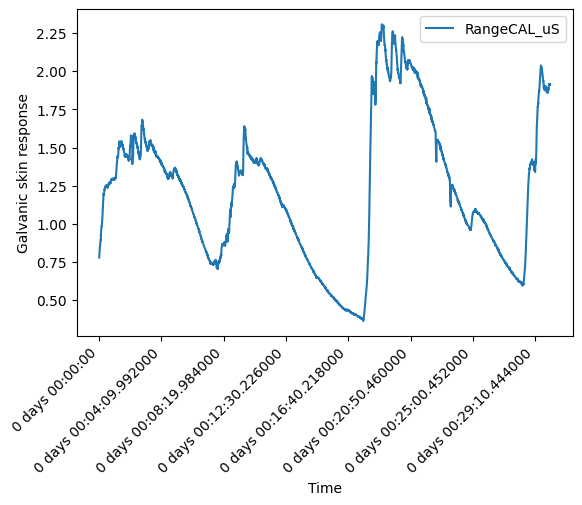

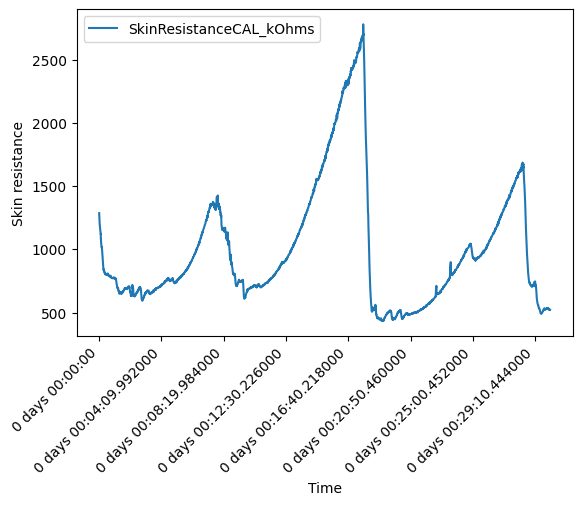

In [7]:
test612_6 = create_df_from_sheet("612_6")
plot_df(test612_6)

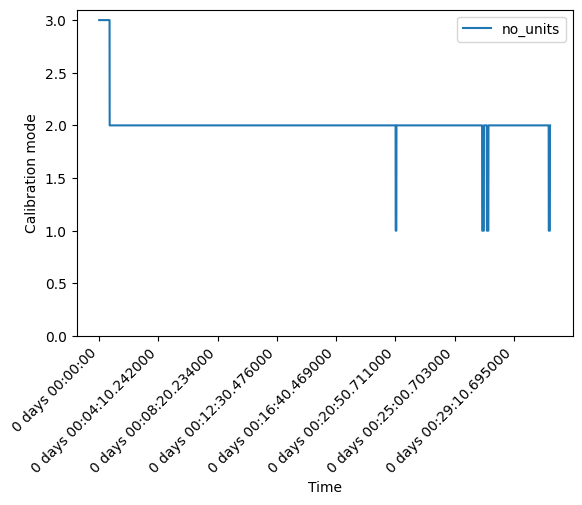

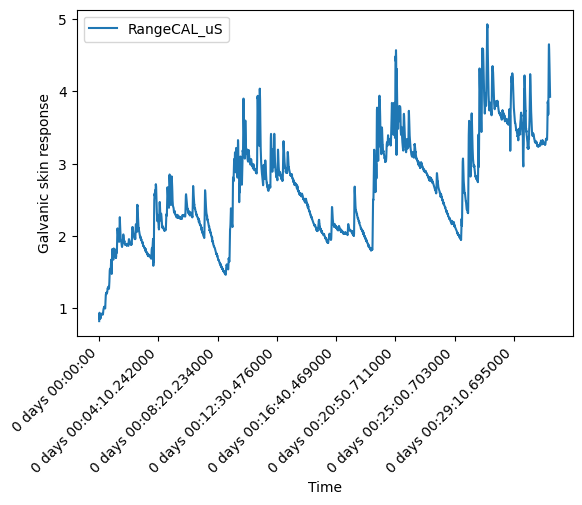

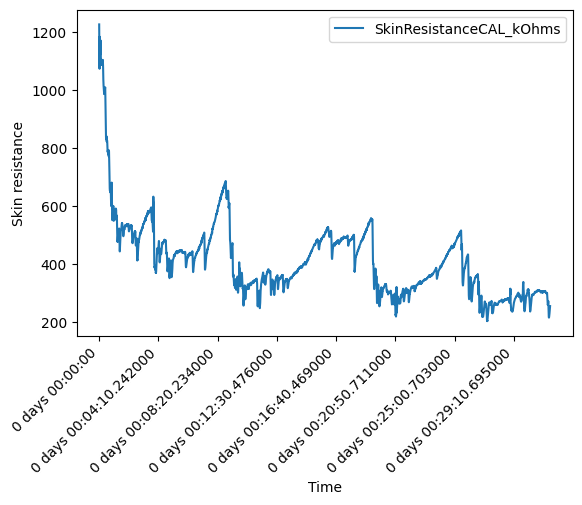

In [8]:
test612_7 = create_df_from_sheet("612_7")
plot_df(test612_7)

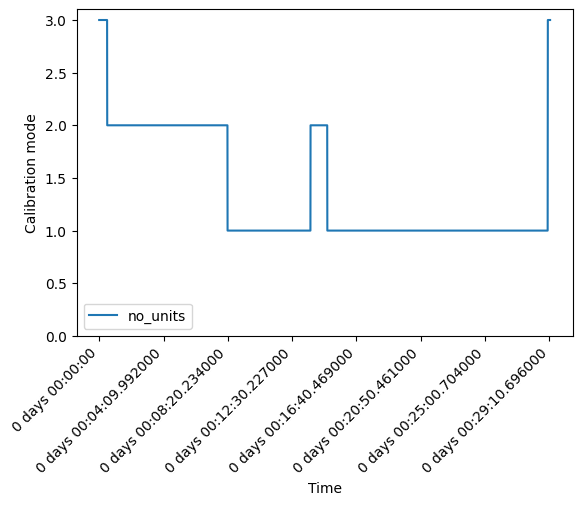

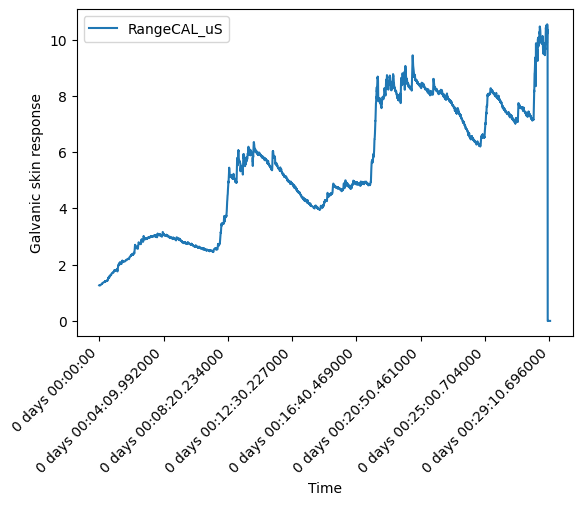

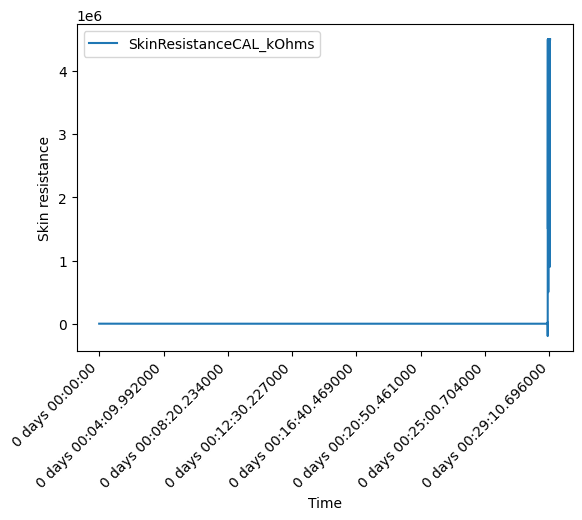

In [9]:
test712_1 = create_df_from_sheet("712_1")
plot_df(test712_1)

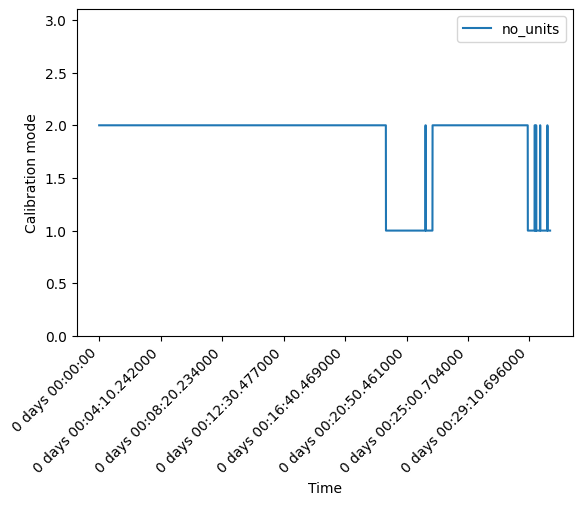

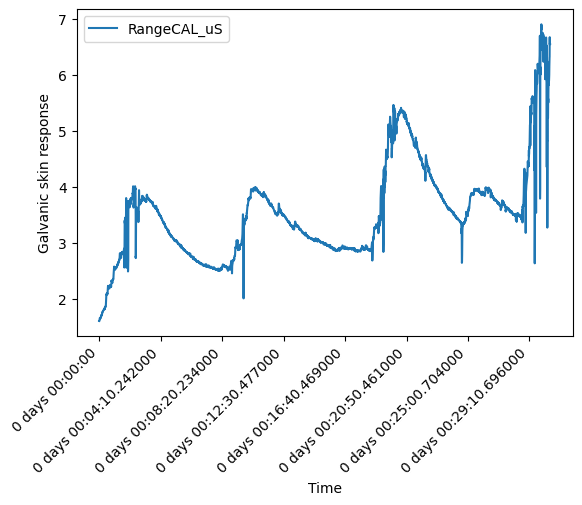

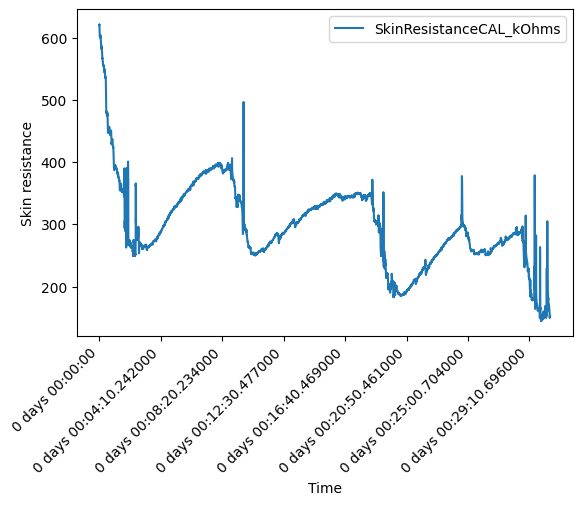

In [10]:
test712_2 = create_df_from_sheet("712_2")
plot_df(test712_2)

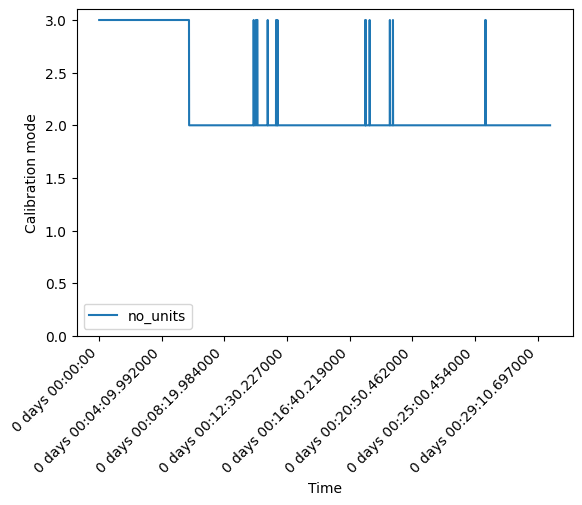

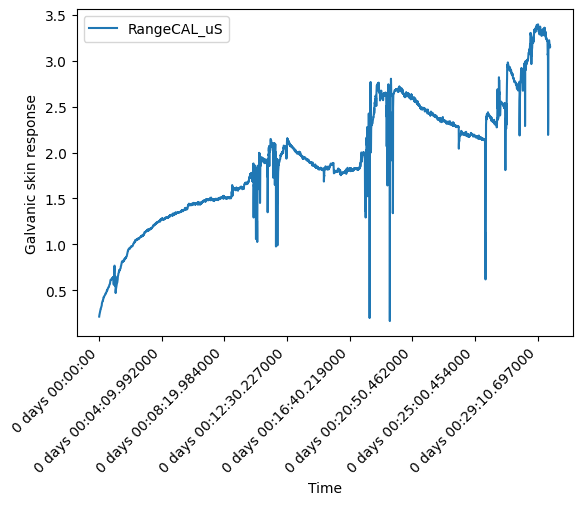

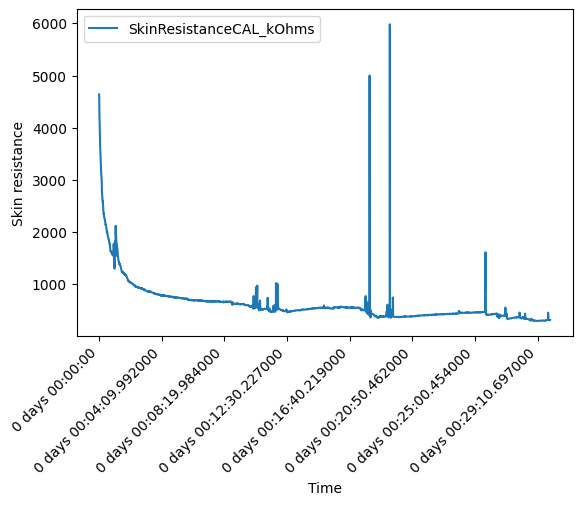

In [11]:
test712_3 = create_df_from_sheet("712_3")
plot_df(test712_3)

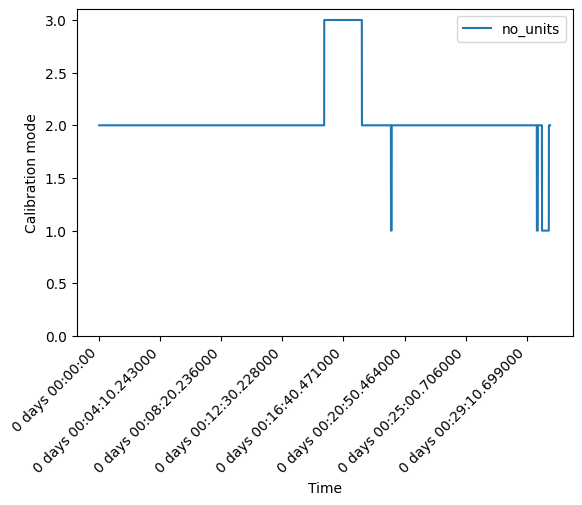

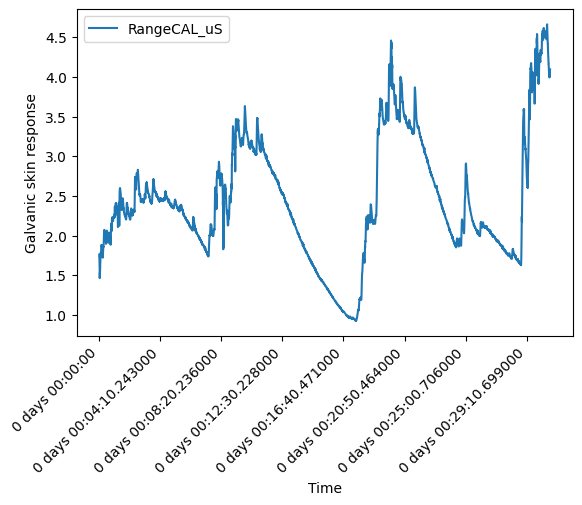

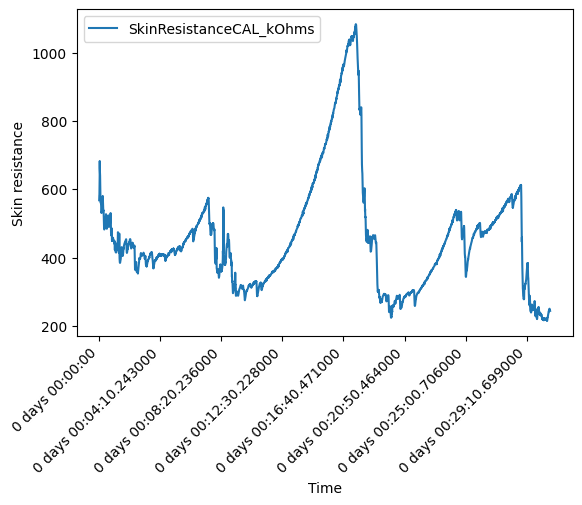

In [12]:
test712_4 = create_df_from_sheet("712_4")
plot_df(test712_4)

In [13]:
# BAD DATA
# test712_5 = create_df_from_sheet("712_5")
# plot_df(test712_5)

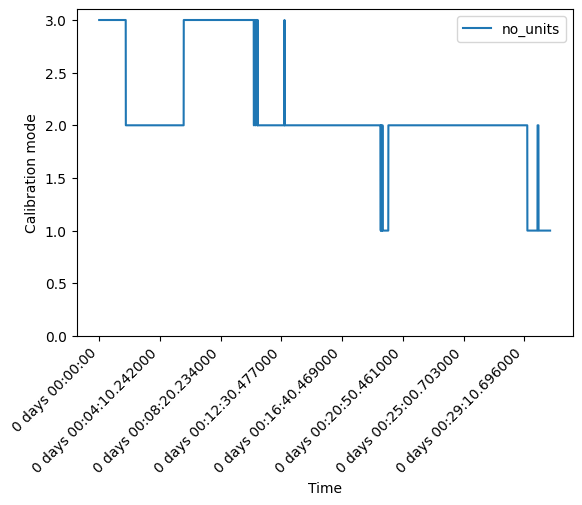

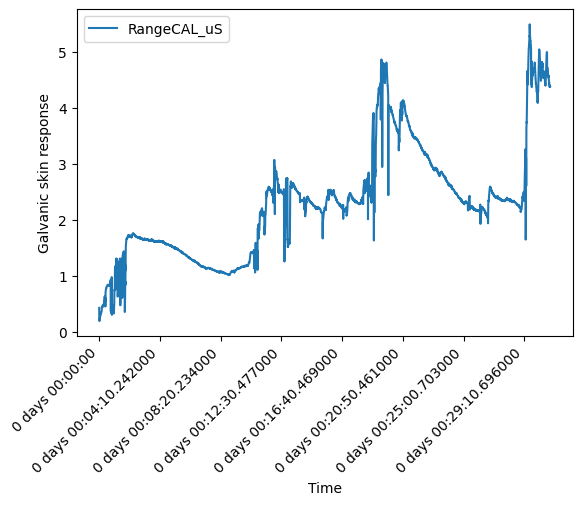

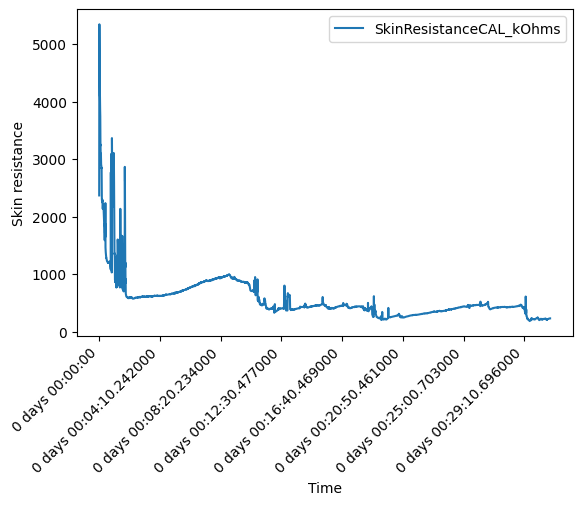

In [14]:
test712_6 = create_df_from_sheet("712_6")
plot_df(test712_6)

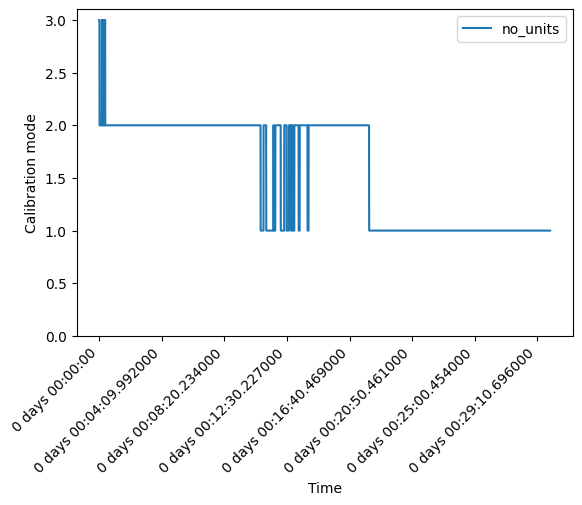

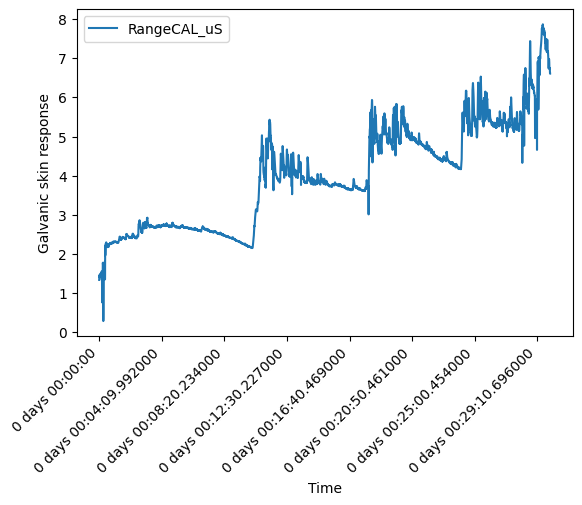

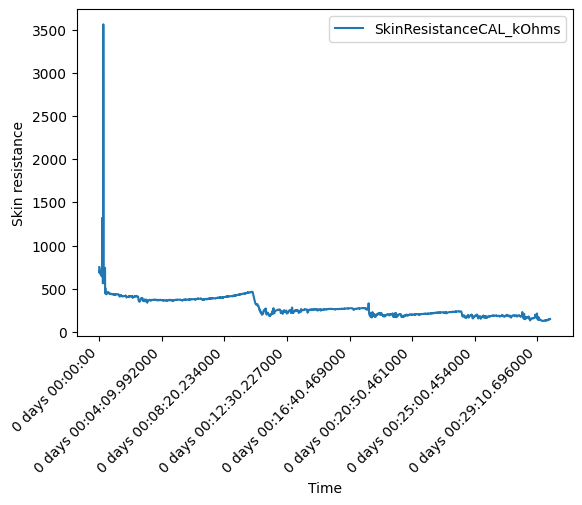

In [15]:
test712_7 = create_df_from_sheet("712_7")
plot_df(test712_7)

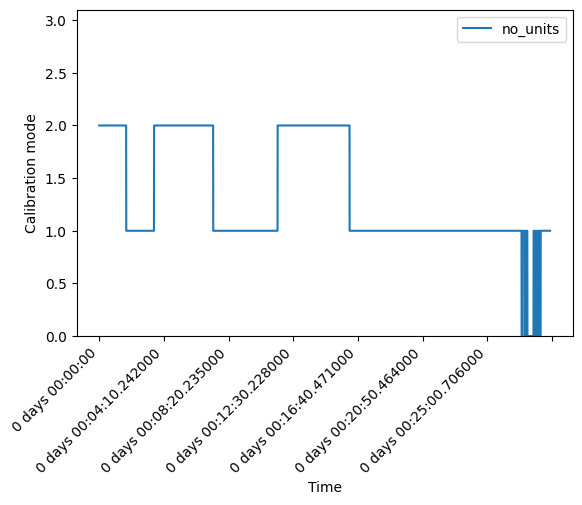

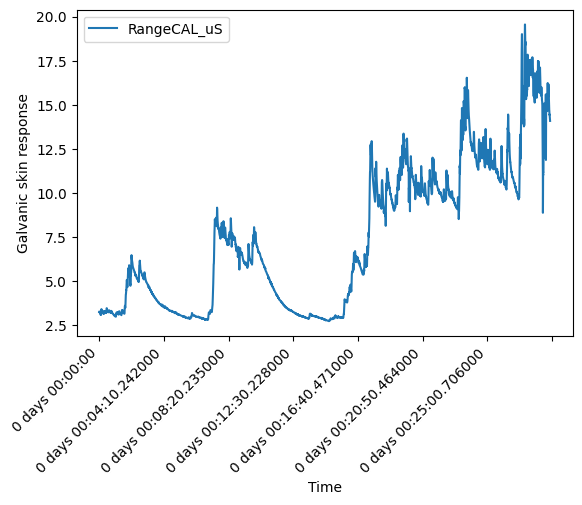

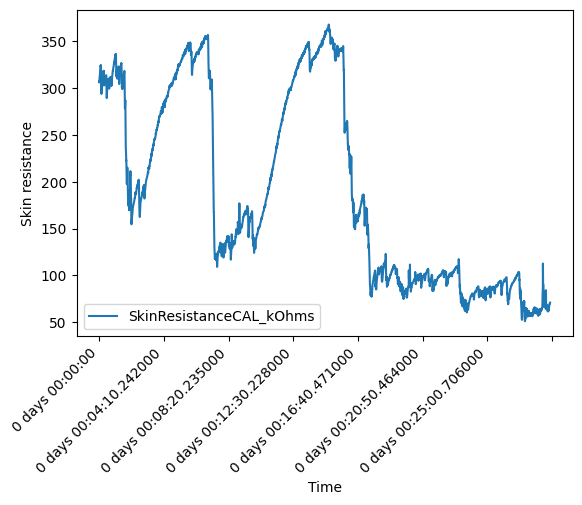

In [16]:
test712_8 = create_df_from_sheet("712_8")
plot_df(test712_8)

# Data preprocessing
Here we select a dataset to use and split it up to do further processing on. We also scale the data from 0 to 1, to make all the data similar so it's easier for the model to pick up on changes. The data can be different from person to person depending on skin conditions and sensor calibration, we've seen values between 0 and 2.25 and values between 0 and 12. 

### random starts here
Run cells below again with "random_dataset = True" to get a random dataset which was loaded in with the "create_df_from_sheet" function. If not set to true, it is possible to manually change the dataset.

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

random_dataset = True

dfTemp= datasetArray[0]
if(random_dataset):
    dfTemp =  np.random.choice(datasetArray)
    print(type(dfTemp))

dfTemp['RangeCAL_uS'] = scaler.fit_transform(dfTemp[['RangeCAL_uS']]) # scale the data so it is all values between 0 and 1 for consistency

# df1_1 = dfTemp.iloc[:, [0, 1]] # calibration value, unused
df1_2 = dfTemp.iloc[:, [0, 2]]
# df1_3 = dfTemp.iloc[:, [0, 3]] # secondary sensor with basically the same values as the first, but with inverted values. unused.
df1_2

<class 'pandas.core.frame.DataFrame'>


/tmp/ipykernel_432/237767304.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dfTemp =  np.random.choice(datasetArray)


,timestamp,RangeCAL_uS
2,0 days 00:00:00,0.138544
3,0 days 00:00:00.250000,0.145331
4,0 days 00:00:00.500000,0.148958
5,0 days 00:00:00.750000,0.152059
6,0 days 00:00:01,0.153346
...,...,...
7203,0 days 00:30:00.944000,0.846619
7204,0 days 00:30:01.194000,0.843255
7205,0 days 00:30:01.444000,0.837201
7206,0 days 00:30:01.694000,0.833837


## Filtering
Here we filter the data. By making a rolling mean or median, we will smooth out the data and remove many outliers. Then we plot the data to find out which one works best, mean or median. In this case it is not very significant, but we decided to go with rolling mean in the end.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7206 entries, 2 to 7207
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   timestamp    7206 non-null   timedelta64[ns]
 1   RangeCAL_uS  7206 non-null   float64        
dtypes: float64(1), timedelta64[ns](1)
memory usage: 112.7 KB


/tmp/ipykernel_432/2499829024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_2['RollingMean'] = df1_2['RangeCAL_uS'].rolling(40).mean() # rolling average of 10 seconds (4 units = 1 second)


<AxesSubplot: xlabel='Time', ylabel='Scaled sensor value'>

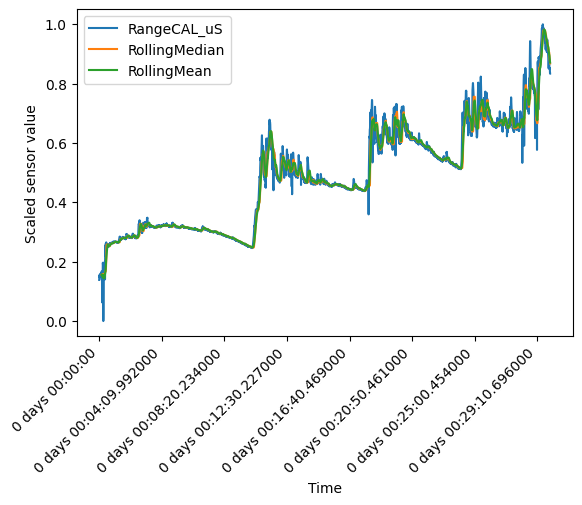

In [18]:
df1_2.info()
df1_2['RollingMean'] = df1_2['RangeCAL_uS'].rolling(40).mean() # rolling average of 10 seconds (4 units = 1 second)
df1_2['RollingMedian'] = df1_2['RangeCAL_uS'].rolling(40).median() # rolling median of 10 seconds
df1_2['deltaMean'] = df1_2.RollingMean.diff(periods =1)
df1_2['deltaMedian'] = df1_2.RollingMedian.diff(periods =1)
df1_2[['RangeCAL_uS','RollingMedian', 'RollingMean','timestamp']].plot(x='timestamp', xlabel='Time', ylabel='Scaled sensor value', rot=45)

Here we copy over only the significant info and drop any rows with NaN values to prevent errors down the line.


In [26]:
anomaly_detection_df = df1_2[['timestamp', 'deltaMean', 'RollingMean']].copy().dropna()
anomaly_detection_df = anomaly_detection_df.reset_index()
# anomaly_detection_df['time_index'] = anomaly_detection_df.index
anomaly_detection_df

,timestamp,deltaMean,RollingMean
42,0 days 00:00:10,0.000706,0.156920
43,0 days 00:00:10.250000,0.000280,0.157200
44,0 days 00:00:10.500000,-0.000240,0.156960
45,0 days 00:00:10.750000,-0.000006,0.156954
46,0 days 00:00:11,0.000016,0.156971
...,...,...,...
7203,0 days 00:30:00.944000,-0.002472,0.880154
7204,0 days 00:30:01.194000,-0.002439,0.877715
7205,0 days 00:30:01.444000,-0.002388,0.875327
7206,0 days 00:30:01.694000,-0.002237,0.873090


# Machine learning

## IsolationForest (unused)
Initially we used an IsolationForest model to detect anomalies in the dataset. The model was pretty accurate with detecting *where* stress moments occurred, but it didn't end up giving us any specific levels of stress, which is what we intend to use in our product. 
One of the positives of this model is that it didn't need any labels on the data, but that also meant that the model was not scoreable on accuracy.

In [20]:
# from sklearn.ensemble import IsolationForest

# IF = IsolationForest(random_state=0, contamination=0.05, n_estimators=200, max_samples=0.7)
# model_data = anomaly_detection_df[['deltaMean']]
# IF.fit(model_data)

# anomaly_detection_df['scores']=IF.decision_function(model_data)
# anomaly_detection_df['anomaly']=IF.predict(model_data)

# anomaly=anomaly_detection_df.loc[anomaly_detection_df['anomaly']==-1]
# anomaly_index=list(anomaly.index)

# print(anomaly)
# # print(anomaly_index)

# anomaly_detection_df[['anomaly', 'RollingMean','deltaMean']].plot(x='timestamp', xlabel='Time', ylabel='', rot=45)

## A bit more data prep
We eventually decided to use DecisionTrees and RandomForest models, which do need labeled data. We label the data below by setting simple thresholds on the scaled data, where we make the assumption that higher values == higher stress. Sadly the datasets we got are not for our specific use case, so we had to make assumptions like these to make a model that **could** work on proper datasets down the line. At the end we split up the data in training and test data, so we can verify the results of our model once it's trained.

/tmp/ipykernel_432/1832149099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stress_level.loc[index, 'stressLevel'] = 0
/tmp/ipykernel_432/1832149099.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stress_level['stressLevel'] = stress_level['stressLevel'].fillna(0) # fill in all the stress levels that weren't filled in with 0
/tmp/ipykernel_432/1832149099.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

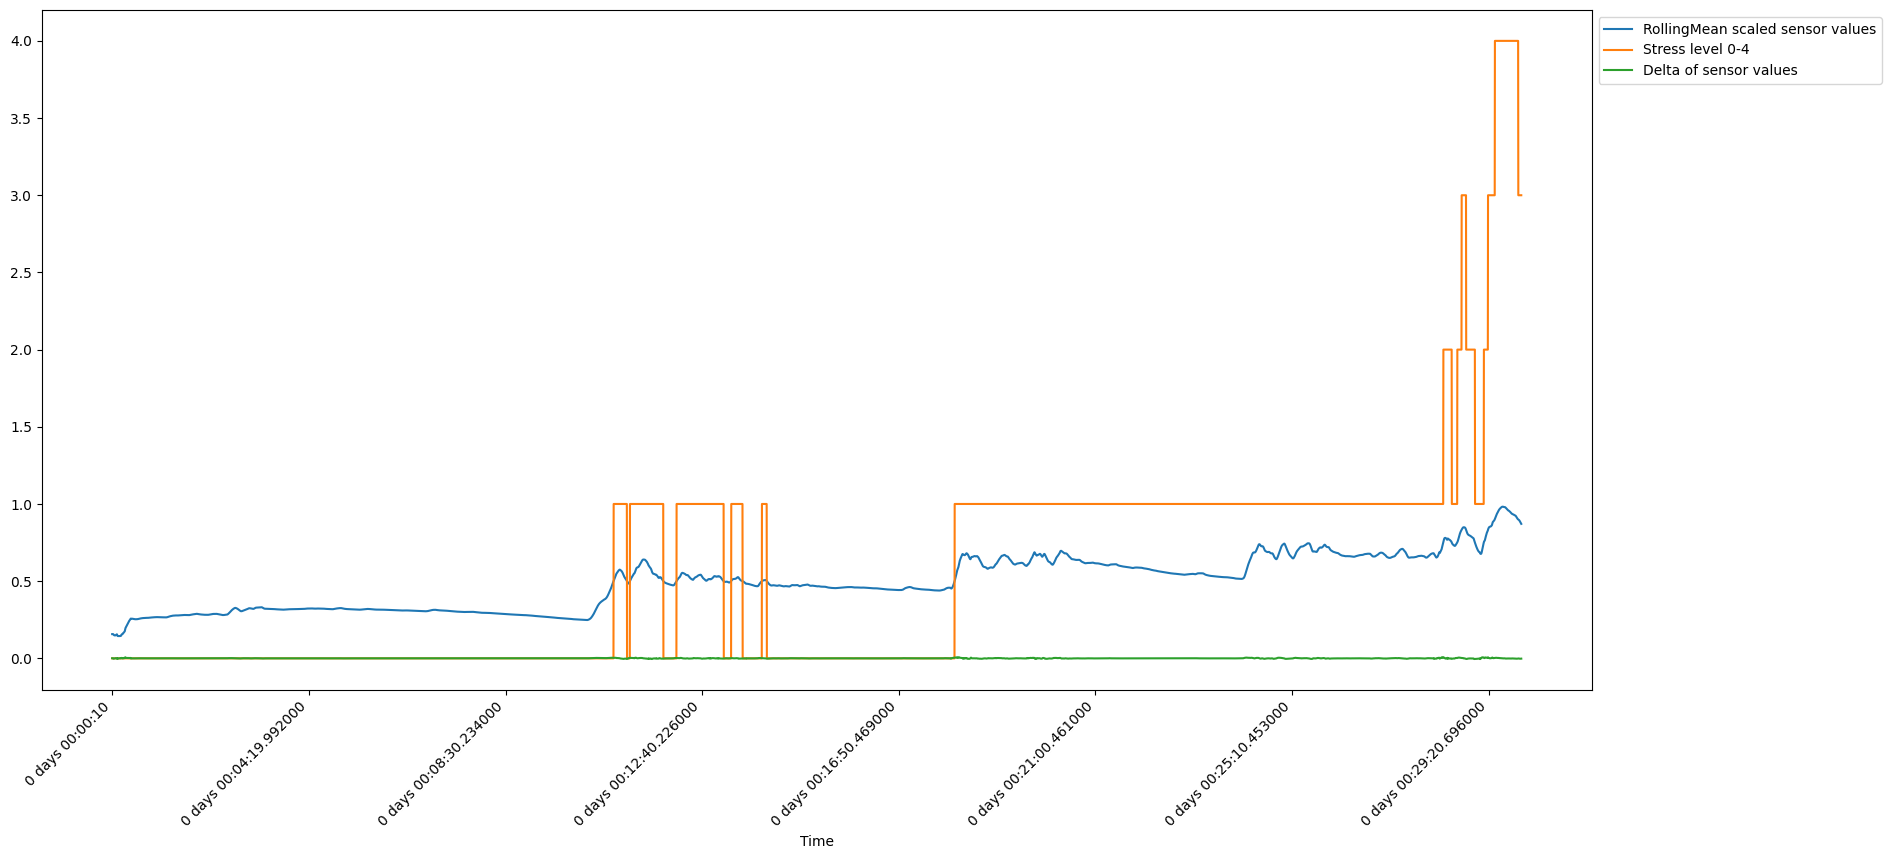

In [38]:
from sklearn.model_selection import train_test_split
stress_level = anomaly_detection_df[['RollingMean', 'deltaMean', 'timestamp']]

for index, row in stress_level.iterrows(): # labeling the data
    if (row[0] > 0.2):
        stress_level.loc[index, 'stressLevel'] = 0
    if (row[0] > 0.4):
        stress_level.loc[index, 'stressLevel'] = 1
    if (row[0] > 0.6):
        stress_level.loc[index, 'stressLevel'] = 2
    if (row[0] > 0.8):
        stress_level.loc[index, 'stressLevel'] = 3
    if (row[0] > 0.9):
        stress_level.loc[index, 'stressLevel'] = 4


stress_level['stressLevel'] = stress_level['stressLevel'].fillna(0) # fill in all the stress levels that weren't filled in with 0
stress_level['weighted'] = (stress_level['stressLevel'] * stress_level['RollingMean']).round(0) # here we multiply the stress level with the current data to get a more detailed graph

stress_level[['RollingMean', 'weighted', 'deltaMean', 'timestamp']].plot(x='timestamp', xlabel='Time', rot=45, figsize=[20, 10])
plt.legend(['RollingMean scaled sensor values','Stress level 0-4','Delta of sensor values'],bbox_to_anchor=(1.0, 1.0))
# stress_level[['stressed','weighted']].plot(x='timestamp', xlabel='Time', ylabel='', rot=45)
model_data = stress_level[['weighted']]
# print(stress_level)

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(
    stress_level[['RollingMean', 'deltaMean']], model_data, test_size=0.25)


## DecisionTree
Here we train and verify our DecisionTree model with the train and test data we split up before. The accuracy is very good, even with other datasets without retraining thanks to the scaling we do.

In [39]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

# comment these out to verify other datasets
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=2)
tree_clf.fit(X_train_data,y_train_data)

# tree.plot_tree(tree_clf);
y_pred = tree_clf.predict(X_test_data)
accuracy_score(y_test_data, y_pred)

0.96875

### DecisionTree result plotting
Here we plot the results of our model in a graph to see if we can find any consistent problems with the model. In this case for example, it is clear that it struggles detecting the higher stress levels as the high stress level data is a very small portion of the training data. We can then solve this by training the model with more high stress level data the next time.

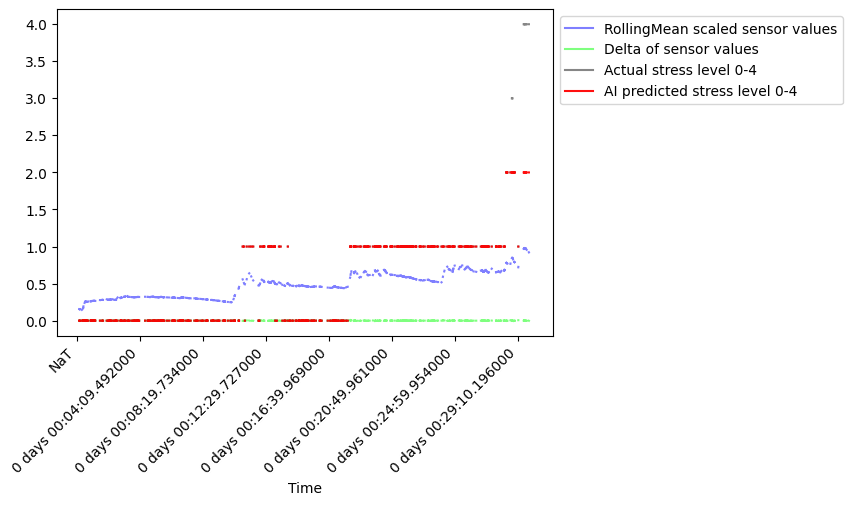

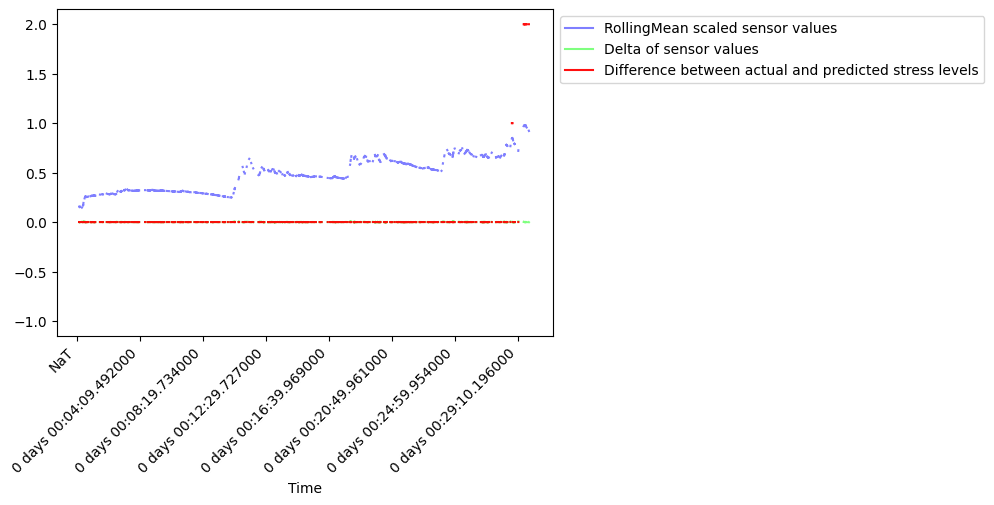

In [40]:
resultPlot = X_test_data.copy()
resultPlot['result']= y_pred.copy()
resultPlot['expected']=y_test_data.copy()

resultPlot = resultPlot.sort_index()
resultPlot_ = resultPlot
for i in resultPlot.iterrows():
    # print(i[0])
    resultPlot_.loc[i[0]]=i[1]
# resultPlot_ = resultPlot_.ffill()

# resultPlot_.reset_index()
# print(resultPlot_)x.resample('D')
resultPlot_2 = resultPlot_.sort_index().reindex(pd.RangeIndex(resultPlot_.index.max() + 1))#.ffill()
resultPlot_2['timestamp']= stress_level['timestamp']
resultPlot_2['errorMargin'] = resultPlot_2['expected']-resultPlot_2['result']
resultPlot_2[['RollingMean','deltaMean','expected', 'result', 'timestamp']].plot(x='timestamp',xlabel='Time', ylabel='', rot=45, style={'RollingMean': '#0000ff80', 'deltaMean': '#00ff0080', 'expected':'#0f0f0f80', 'result':'#ff0000f0'})#, figsize=[20,10])
plt.legend(['RollingMean scaled sensor values','Delta of sensor values','Actual stress level 0-4','AI predicted stress level 0-4'],bbox_to_anchor=(1.0, 1.0))
resultPlot_2[['RollingMean','deltaMean','errorMargin','timestamp']].plot(x='timestamp', xlabel='Time', ylabel='', rot=45, style={'RollingMean': '#0000ff80', 'deltaMean': '#00ff0080','errorMargin':'#ff0000f0'})#, figsize=[20,10])
plt.legend(['RollingMean scaled sensor values','Delta of sensor values','Difference between actual and predicted stress levels'],bbox_to_anchor=(1.0, 1.0))

## RandomForest
Here we train and verify our RandomForest model, same as the DecisionTree model. The accuracy may be slightly worse, but it is still very high and more consistent than the DecisionTree models.

In [41]:
from sklearn.ensemble import RandomForestClassifier

# comment these out to verify other datasets
forest_clf = RandomForestClassifier(criterion='entropy', max_depth=2, min_samples_split=2, n_estimators = 50)
forest_clf.fit(X_train_data,y_train_data)

y_pred = forest_clf.predict(X_test_data)
accuracy_score(y_test_data, y_pred)

/tmp/ipykernel_432/3949181303.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_clf.fit(X_train_data,y_train_data)


0.9536830357142857

### RandomForest result plotting
Here we plot the results of our model in a graph to see if we can find any consistent problems with the model. In this case for example, it is clear that it struggles detecting the higher stress levels as the high stress level data is a very small portion of the training data. We can then solve this by training the model with more high stress level data the next time.

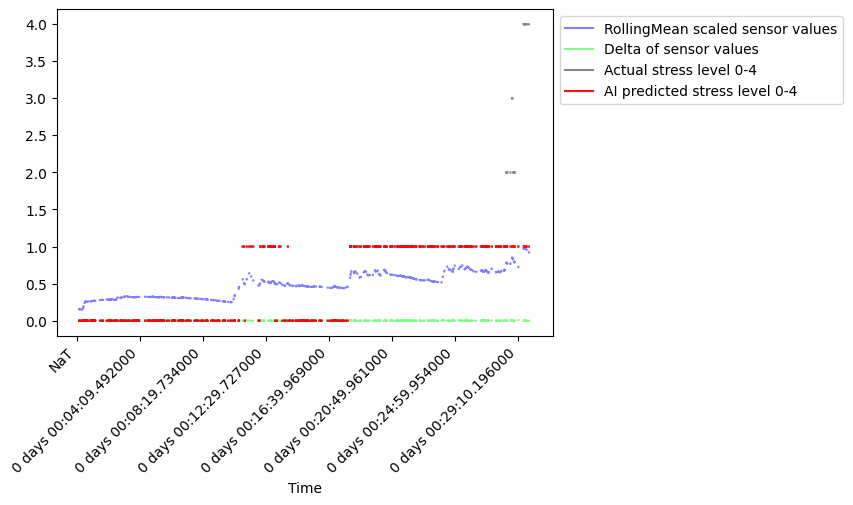

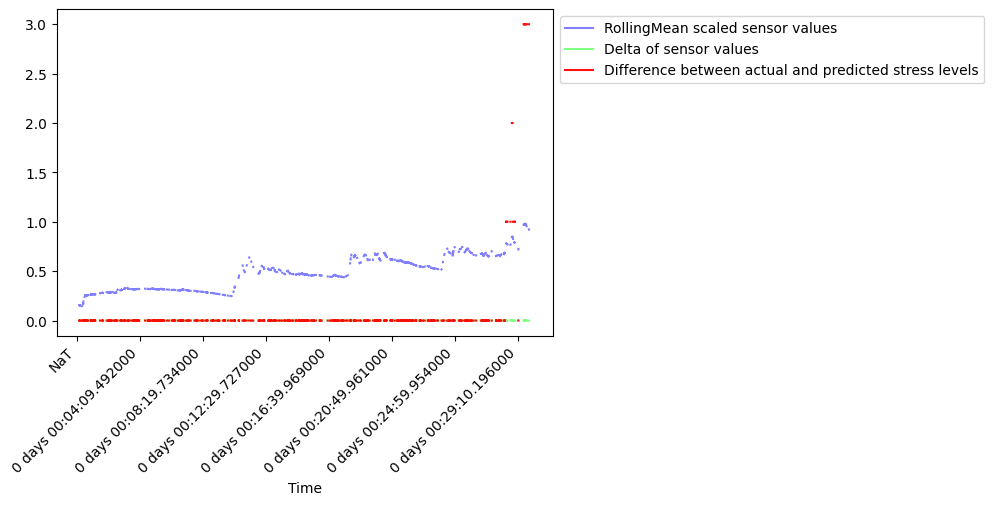

In [44]:
resultPlot = X_test_data.copy()
resultPlot['result']= y_pred.copy()
resultPlot['expected']=y_test_data.copy()

resultPlot = resultPlot.sort_index()
resultPlot_ = resultPlot
for i in resultPlot.iterrows():
    # print(i[0])
    resultPlot_.loc[i[0]]=i[1]
# resultPlot_ = resultPlot_.ffill()

# resultPlot_.reset_index()
# print(resultPlot_)x.resample('D')
resultPlot_2 = resultPlot_.sort_index().reindex(pd.RangeIndex(resultPlot_.index.max() + 1))#.ffill()
resultPlot_2['timestamp']= stress_level['timestamp']
resultPlot_2['errorMargin'] = resultPlot_2['expected']-resultPlot_2['result']
resultPlot_2[['RollingMean','deltaMean','expected', 'result', 'timestamp']].plot(x='timestamp',xlabel='Time', ylabel='', rot=45, style={'RollingMean': '#0000ff80', 'deltaMean': '#00ff0080', 'expected':'#0f0f0f80', 'result':'#ff0000f0'})#, figsize=[20,10])
plt.legend(['RollingMean scaled sensor values','Delta of sensor values','Actual stress level 0-4','AI predicted stress level 0-4'],bbox_to_anchor=(1.0, 1.0))
resultPlot_2[['RollingMean','deltaMean','errorMargin','timestamp']].plot(x='timestamp', xlabel='Time', ylabel='', rot=45, style={'RollingMean': '#0000ff80', 'deltaMean': '#00ff0080','errorMargin':'#ff0000f0'})#, figsize=[20,10])
plt.legend(['RollingMean scaled sensor values','Delta of sensor values','Difference between actual and predicted stress levels'],bbox_to_anchor=(1.0, 1.0))

In [43]:
# arima or sarima
# plot time series instead of measurement index
# look at different model types

# ARIMA exploration
In this part we will explore if the ARIMA time series model is suitable for our use cases by following [this tutorial](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3).